<b>Data Source:</b><br>
<b>Forbes World's Billionaires List 2024, Vincent Campanaro.</b><br>
<b>Retrieved from</b> https://www.kaggle.com/datasets/vincentcampanaro/forbes-worlds-billionaires-list-2024

# Importing Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

## Load the data

In [5]:
data = pd.read_csv('2024-Billionaire.csv')
data

,Name,Age,2024 Net Worth,Industry,Source of Wealth,Title,Organization,Self-Made,Self-Made Score,Philanthropy Score,Residence,Citizenship,Gender,Marital Status,Children,Education
0,Bernard Arnault & family,75.0,$233B,Fashion & Retail,LVMH,Chairman and CEO,LVMH Moët Hennessy Louis Vuitton,False,NaN,NaN,"Paris, France",France,M,Married,5.0,"Bachelor of Arts/Science, Ecole Polytechnique ..."
1,Elon Musk,52.0,$195B,Automotive,"Tesla, SpaceX",CEO,Tesla,True,8.0,1.0,"Austin, Texas",United States,M,Single,11.0,"Bachelor of Arts/Science, University of Pennsy..."
2,Jeff Bezos,60.0,$194B,Technology,Amazon,Chairman and Founder,Amazon,True,8.0,2.0,"Miami, Florida",United States,M,Engaged,4.0,"Bachelor of Arts/Science, Princeton University"
3,Mark Zuckerberg,39.0,$177B,Technology,Facebook,Co-founder,Meta Platforms,True,8.0,2.0,"Palo Alto, California",United States,M,Married,3.0,"Drop Out, Harvard University"
4,Larry Ellison,79.0,$141B,Technology,Oracle,CTO and Founder,Oracle,True,9.0,1.0,"Woodside, California",United States,M,In Relationship,4.0,"Drop Out, University of Chicago; Drop Out, Uni..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2776,Zhang Hong,NaN,$1B,Energy,Solar,NaN,NaN,True,NaN,NaN,"Hangzhou, China",China,F,Married,NaN,NaN
2777,Zheng Xiaodong,60.0,$1B,Manufacturing,Manufacturing,NaN,NaN,True,NaN,NaN,"Shanghai, China",China,M,NaN,NaN,NaN
2778,Zhong Sheng Jian,66.0,$1B,Real Estate,Real estate,founder,Yanlord Land Group Limited,True,NaN,NaN,"Singapore, Singapore",Singapore,M,Married,5.0,NaN
2779,Zhou Junjie,55.0,$1B,Manufacturing,equipment,Chairperson,Yindu Kitchen Equipment,True,NaN,NaN,"Hangzhou, China",China,M,Married,NaN,NaN


## Data selection

In [7]:
data_cleaned = data[['Age','2024 Net Worth']]
data_cleaned

,Age,2024 Net Worth
0,75.0,$233B
1,52.0,$195B
2,60.0,$194B
3,39.0,$177B
4,79.0,$141B
...,...,...
2776,NaN,$1B
2777,60.0,$1B
2778,66.0,$1B
2779,55.0,$1B


In [8]:
data_cleaned.dtypes

Age               float64
2024 Net Worth     object
dtype: object

In [9]:
data_cleaned.loc[:, '2024 Net Worth'] = data_cleaned['2024 Net Worth'].replace(r'[\$,B]', '', regex=True).astype(float)
data_cleaned

,Age,2024 Net Worth
0,75.0,233.0
1,52.0,195.0
2,60.0,194.0
3,39.0,177.0
4,79.0,141.0
...,...,...
2776,NaN,1.0
2777,60.0,1.0
2778,66.0,1.0
2779,55.0,1.0


The '2024 Net Worth' values are originally strings containing non-numeric characters like the dollar sign ($) and the letter B (which stands for "billion"). These characters prevent numerical operations, such as plotting, mathematical calculations, and clustering. Therefore we change it into float.

### Check for null value and drop the null value.

In [12]:
data_cleaned.isnull().sum()

Age               81
2024 Net Worth     0
dtype: int64

In [13]:
data_cleaned = data_cleaned.dropna(subset=['Age'])
data_cleaned.isnull().sum()

Age               0
2024 Net Worth    0
dtype: int64

## Plot the data

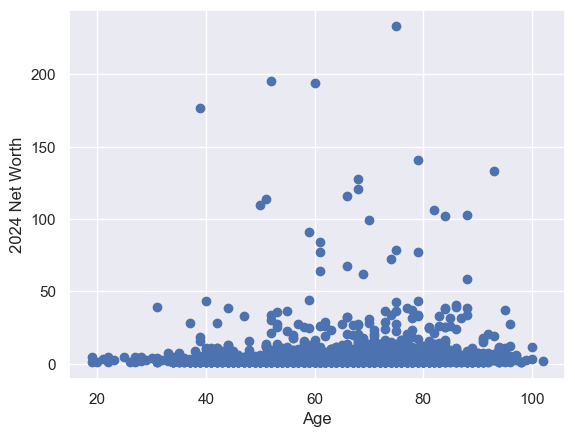

In [15]:
plt.scatter(data_cleaned['Age'],data_cleaned['2024 Net Worth'])
plt.xlabel('Age')
plt.ylabel('2024 Net Worth')
plt.show()

There is no strong linear correlation between age and net worth. High net worth individuals appear across various age groups, including those in their 40s to 80s.

The plot suggests that net worth is not solely dependent on age, but likely influenced by other variables like industry, inheritance, or entrepreneurship success.

## Standardize the variables

In [18]:
from sklearn import preprocessing
x_scaled = preprocessing.scale(data_cleaned)
x_scaled

array([[ 0.68829739, 18.37691302],
       [-1.02027151, 15.31131243],
       [-0.42598667, 15.23063874],
       ...,
       [ 0.01972695, -0.33938529],
       [-0.79741469, -0.33938529],
       [-0.42598667, -0.33938529]])

## The Elbow Method
We used the Elbow Method is in clustering to determine the optimal number of clusters by plotting the Within-Cluster Sum of Squares (WCSS) against various values of k. As the number of clusters increases, WCSS decreases, but at a certain point, the rate of improvement drops significantly—forming an "elbow" in the plot. This elbow point represents the best balance between cluster compactness and simplicity, helping to avoid both underfitting and overfitting in KMeans clustering. For short, this is used to determined the right amount of clusters we should use.

### WCSS

In [21]:
wcss = []
# 'cl_num' is a that keeps track the highest number of clusters we want to use the WCSS method for. We have it set at 10 right now, but it is completely arbitrary.
cl_num = 10
for i in range (1,cl_num):
    kmeans= KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
wcss

[5400.0,
 3624.3838348574504,
 1767.6211367374212,
 1344.7307626006207,
 1118.4519599835705,
 835.8739780676002,
 784.5510472082985,
 543.3125506952724,
 532.8239879797444]

Text(0, 0.5, 'Within-cluster Sum of Squares')

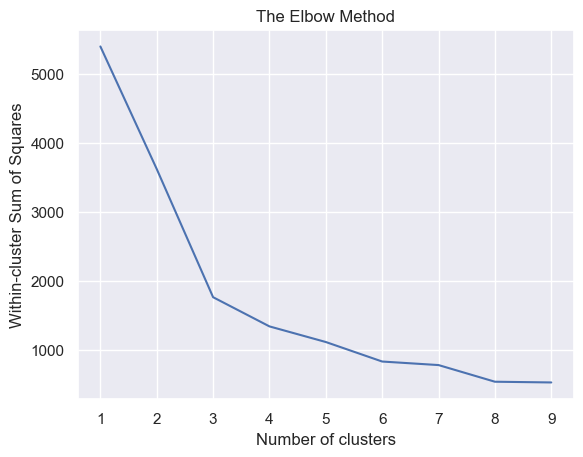

In [22]:
number_clusters = range(1,cl_num)
plt.plot(number_clusters, wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')

## 3 Cluster 
Based on the Elbow Method plot, we choose 3 clusters because it represents the point where the Within-Cluster Sum of Squares (WCSS) begins to decrease at a slower rate—forming an "elbow" in the graph. This indicates that adding more clusters beyond this point results in only marginal improvements in compactness and model performance. Therefore, 3 clusters provide a good balance between simplification and capturing the underlying structure of the data without overfitting.

In [24]:
kmeans_3 = KMeans(3)
kmeans_3.fit(x_scaled)
clusters_3 = data_cleaned.copy()
clusters_3['cluster_pred']=kmeans_3.fit_predict(x_scaled)

Text(0, 0.5, '2024 Net Worth (Billion USD)')

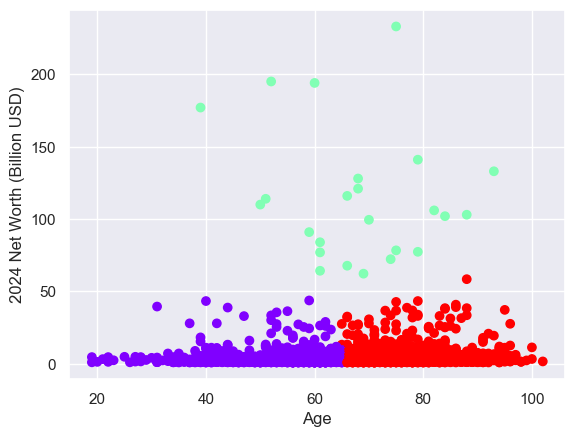

In [25]:
plt.scatter(clusters_3['Age'], clusters_3['2024 Net Worth'], c= clusters_3 ['cluster_pred'], cmap = 'rainbow')
plt.xlabel('Age')
plt.ylabel('2024 Net Worth (Billion USD)')

# Conclution

<p>
The clustering analysis of billionaires using <b>Age</b> and <b>2024 Net Worth</b> reveals distinct patterns in how wealth is distributed across generations. The youngest group, typically under 40, tends to cluster at the lower range of net worth. These individuals are often recent tech entrepreneurs or heirs to established fortunes who haven't had as much time to accumulate massive wealth. While they are billionaires by definition, their wealth typically falls below <b>$50 billion</b>, and their position in the scatter plot shows a more concentrated distribution toward the lower left.
</p>

<p>
In contrast, the middle-aged segment (ages 40 to 60) shows a broader spread in net worth, indicating active wealth creation. This group includes many <b>self-made billionaires</b>, especially in sectors like technology, finance, and manufacturing. Their net worth varies greatly, and they tend to be more evenly distributed across the mid-section of the plot. These individuals are often in the midst of scaling their businesses or managing large investment portfolios, resulting in a dynamic growth trajectory.
</p>

<p>
The <b>Top Net Worth Elite</b> cluster is particularly prominent — composed of individuals mostly aged 50 to 90, with net worths exceeding <b>$100 billion</b>. These billionaires represent the uppermost tier of global wealth. Many are either long-established legacy figures or high-impact founders of tech giants whose companies have grown exponentially. What sets this group apart is that their wealth does not follow a clear age-based trend; some reached extreme wealth at relatively younger ages, while others accumulated it steadily over time. This vertical distribution in the plot underscores that <b>age is not a limiting factor</b> at this level — wealth here is a reflection of <b>market dominance, global influence, and sustained economic success</b>.
</p>